# PROTOTYPE OF FINAL PROJECT

In [27]:
#IMPORTS

import pandas as pd
import datetime
import seaborn as sns
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import  RobustScaler
from tensorflow.keras.layers import Lambda
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
import os

In [2]:
#GETTING CURRENCY RATES

def currency_converter():

    APIkey = "j4YVbY4DsPe2bRdqchwWzvccCljEhg2EhlPyfrEN"
    url = f"https://api.freecurrencyapi.com/v1/latest?apikey={APIkey}"
    response = requests.get(url).json()
    df = pd.DataFrame(response['data'], index=[0])
    return df

currency_converter()

,AUD,BGN,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,...,PHP,PLN,RON,RUB,SEK,SGD,THB,TRY,USD,ZAR
0,1.493637,1.867291,5.235649,1.365095,0.942015,6.996148,23.238091,7.106238,0.955433,0.824367,...,55.881227,4.481577,4.695386,60.551458,10.415155,1.358734,35.090356,18.632194,1,17.331527


In [3]:
#GETTING FEAR GRID VALUES

def fgindex() -> pd.DataFrame:
    """returns a dataframe of fear and greed index with columns:
    [value],[value_classification],[timestamp],[time_until_update] """

    url = 'https://api.alternative.me/fng/'
    params = {'limit':100000,'date_format':'world'}
    response = requests.get(url,params).json()
    fg = pd.DataFrame(response['data'])
    return fg

fgindex()

,value,value_classification,timestamp,time_until_update
0,29,Fear,07-12-2022,-1670318185
1,25,Extreme Fear,06-12-2022,NaN
2,26,Fear,05-12-2022,NaN
3,26,Fear,04-12-2022,NaN
4,27,Fear,03-12-2022,NaN
...,...,...,...,...
1763,11,Extreme Fear,05-02-2018,NaN
1764,24,Extreme Fear,04-02-2018,NaN
1765,40,Fear,03-02-2018,NaN
1766,15,Extreme Fear,02-02-2018,NaN


In [4]:
! pip install Historic-Crypto


In [5]:
from Historic_Crypto import HistoricalData

In [6]:
#GETTING CLOSING PRICES OF CRYPTO CURRENCY

crypto = 'BTC'

def prices(crypto)-> pd.DataFrame:

    today = datetime.datetime.today().strftime('%Y-%m-%d')
    crypto_df = HistoricalData(f'{crypto}-USD',86400,'2018-01-31-00-00',f"{today}-00-00",verbose = False).retrieve_data()
    return crypto_df

prices(crypto)


Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


,low,high,open,close,volume
time,,,,,
2018-02-01,8400.00,10166.25,10099.99,9014.23,38171.970034
2018-02-02,7540.00,9090.08,9014.22,8787.52,52039.268077
2018-02-03,8115.48,9499.00,8787.52,9240.00,23700.985090
2018-02-04,7859.00,9350.00,9227.80,8167.91,24062.181957
2018-02-05,6425.75,8349.16,8167.90,6905.19,59578.698221
...,...,...,...,...,...
2022-12-03,16863.58,17158.42,17094.25,16888.53,14081.450672
2022-12-04,16882.86,17199.99,16889.17,17108.90,16961.108288
2022-12-05,16865.22,17424.59,17108.90,16966.05,33618.451090


In [7]:
def data_cleaning(crypto = 'BTC'):
    '''The function returns a dataframe containing:
    price: the historical crypto price
    index: the Grid/fear index value
    '''
    #cleaning the price data

    BTC_USD = prices(crypto)
    BTC_USD= BTC_USD['close']

    #cleaning the sentiment data
    sentiment_data = fgindex()
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['value'] = sentiment_data['value'].astype('float')
    fg= pd.DataFrame(sentiment_data[['value', 'timestamp']])
    fg.set_index('timestamp', inplace=True)


    #merging the price and sentiment data
    df = fg.join(BTC_USD)

    #cleaning the merged dataframe
    df.dropna(inplace=True)
    df.rename(columns = {'close': 'price', 'value': 'index'}, inplace = True)

    return df

df = data_cleaning()

df.info()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1753 entries, 2022-07-12 to 2018-02-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1753 non-null   float64
 1   price   1753 non-null   float64
dtypes: float64(2)
memory usage: 41.1 KB


/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '27-11-2022' in DD/MM/YYYY f

From Challenge `predict temperature` 

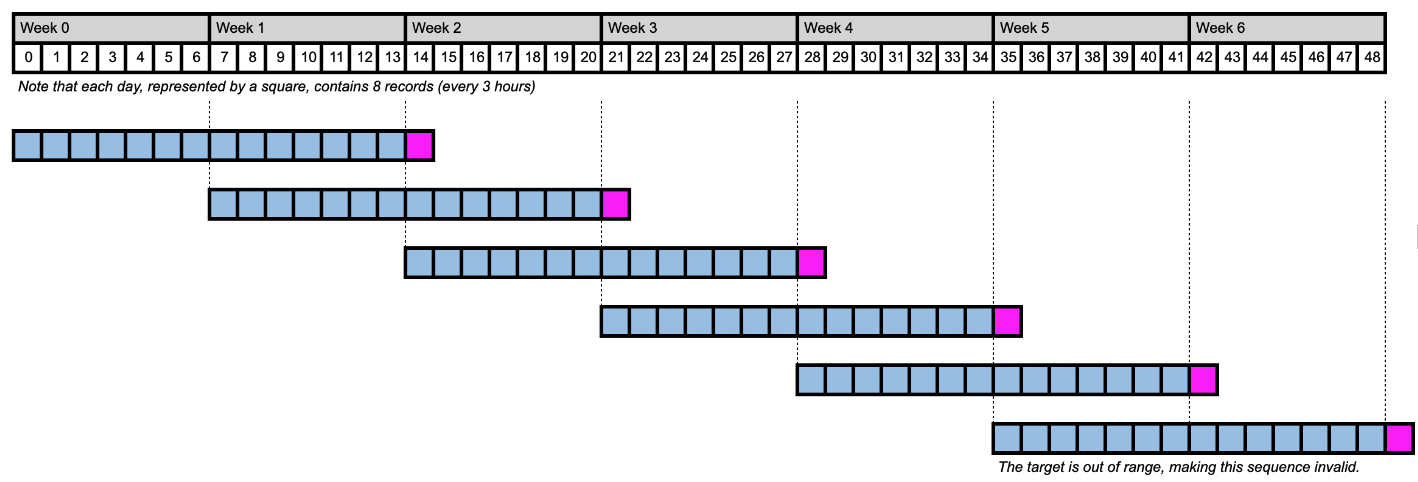

In [8]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y


def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


In [9]:
# Predict Closing Prices using a 10 day window of fear and greed index values and a target of the 11th day closing price
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 1 is the `Close` column
feature_column = 0 #df.columns.get_loc('index')
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)


In [10]:
len(X)

1742

In [11]:
# Use 70% of the data for training and the remainder for testing

# x split
split = int(.7 * len(X))
X_train = X[:split - 1]
X_test = X[split:]

# y split
y_train = y[:split - 1]
y_test = y[split:]

In [12]:
len(X_train)

1218

<AxesSubplot:>

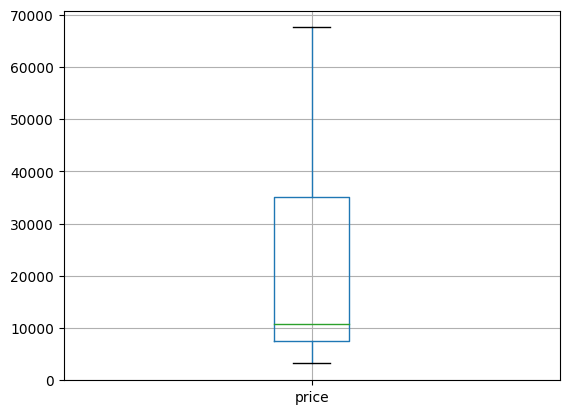

In [13]:
boxplot = df.boxplot(column=['price'])
boxplot

In [14]:
# Use RobustScaler to scale the data between 0 and 1

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [15]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


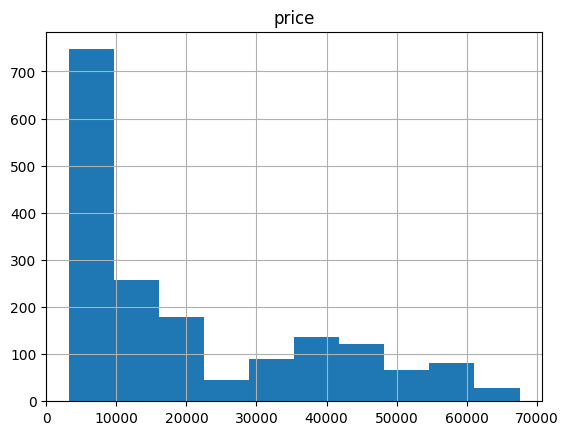

In [16]:
histogram = df.hist(column=['price'])
plt.show()

In [17]:
def window_data(crypto='BTC',window=10):
    """returns two arrays:
    X : Array of lists. Each list contains n_window observations of features.
    y: Array of lists. Each list contains the price of obs n_window + 1
    """
    df = data_cleaning(crypto)
    feature_column = df.columns.get_loc('index')
    target_column = df.columns.get_loc('price')
    X = []
    y = []

    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_column]
        target = df.iloc[(i + window), target_column]
        X.append(features)
        y.append(target)

    return np.array(X), np.array(y).reshape(-1, 1)

In [18]:
window_data()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Pro

(array([[29., 25., 26., ..., 29., 26., 28.],
        [25., 26., 26., ..., 26., 28., 26.],
        [26., 26., 27., ..., 28., 26., 22.],
        ...,
        [71., 55., 35., ..., 30., 36.,  8.],
        [55., 35., 42., ..., 36.,  8., 11.],
        [35., 42., 31., ...,  8., 11., 24.]]),
 array([[16419.88],
        [16450.93],
        [16510.9 ],
        ...,
        [ 9190.48],
        [ 7045.01],
        [11000.  ]]))

In [19]:
def folds(crypto='BTC',window=10):
    """ returns four arrays:
    X_train : array of lists with the 70% of the observed feature values
    X_test : array of lists with the 30% of the observed feature values
    y_train : array of lists with the 70% of the observed target values
    y_test : array of lists with the 30% of the observed target values
    """

    X, y = window_data(crypto,window)
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]

    return X_train,X_test,y_train,y_test

In [20]:
folds()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Pro

(array([[29., 25., 26., ..., 29., 26., 28.],
        [25., 26., 26., ..., 26., 28., 26.],
        [26., 26., 27., ..., 28., 26., 22.],
        ...,
        [66., 64., 62., ..., 22., 19., 16.],
        [64., 62., 61., ..., 19., 16., 47.],
        [62., 61., 61., ..., 16., 47., 24.]]),
 array([[61., 57., 31., ..., 24., 42., 20.],
        [57., 31., 22., ..., 42., 20., 40.],
        [31., 22., 19., ..., 20., 40., 42.],
        ...,
        [71., 55., 35., ..., 30., 36.,  8.],
        [55., 35., 42., ..., 36.,  8., 11.],
        [35., 42., 31., ...,  8., 11., 24.]]),
 array([[16419.88],
        [16450.93],
        [16510.9 ],
        ...,
        [ 9479.98],
        [ 9843.  ],
        [ 9883.33]]),
 array([[ 9840.12],
        [10323.39],
        [10590.7 ],
        [10761.03],
        [10538.06],
        [10649.07],
        [ 9696.31],
        [ 9422.72],
        [10854.47],
        [10185.03],
        [11370.08],
        [ 7502.19],
        [ 9198.84],
        [ 8209.  ],
        [10484.

In [21]:
def scaling(crypto='BTC',window=10):
    """ returns four arrays:
    X_train_scaled : array of lists with the 70% of the observed feature values scaled,
    X_test_scaled : array of lists with the 30% of the observed feature values scaled,
    y_train_scaled : array of lists with the 70% of the observed target values scaled,
    y_test_scaled : array of lists with the 30% of the observed target values scaled.
    """

    scaler = RobustScaler()
    X_train,X_test,y_train,y_test = folds(crypto,window)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

In [49]:
X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled= scaling()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Pro

In [45]:
def reshape(crypto='BTC',window=10):
    X_train_scaled,X_test_scaled = scaling(crypto,window)[0],scaling(crypto,window)[1]
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    return X_train,X_test

In [46]:
X_train,X_test = reshape()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Pro

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


/Users/monic/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '30-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '29-11-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
/var/folders/bs/pzl9llpn4z9d1kxlsk4k87y00000gn/T/ipykernel_7867/892068161.py:13: UserWarning: Parsing '28-11-2022' in DD/MM/YYYY format. Pro

In [47]:
X_train.shape

(1218, 10, 1)

In [48]:
X_test.shape

(523, 10, 1)

In [ ]:
y_test

## Baseline Model

In [53]:
def init_baseline():


    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,0,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [54]:
baseline_model = init_baseline()

In [52]:
X_test[:,-1,0,None]

array([[-0.51351351],
       [ 0.02702703],
       [ 0.08108108],
       [ 0.08108108],
       [-0.13513514],
       [ 0.08108108],
       [ 0.02702703],
       [-0.54054054],
       [-0.13513514],
       [-0.62162162],
       [ 0.59459459],
       [ 0.7027027 ],
       [-0.16216216],
       [ 0.62162162],
       [ 1.18918919],
       [ 1.21621622],
       [ 0.94594595],
       [ 0.75675676],
       [ 0.89189189],
       [ 0.75675676],
       [ 1.        ],
       [ 1.08108108],
       [ 0.64864865],
       [ 0.7027027 ],
       [ 1.05405405],
       [ 0.94594595],
       [ 0.62162162],
       [ 1.43243243],
       [ 1.51351351],
       [ 1.2972973 ],
       [ 1.10810811],
       [ 1.21621622],
       [ 1.18918919],
       [ 1.21621622],
       [ 1.13513514],
       [ 1.16216216],
       [ 1.18918919],
       [ 1.21621622],
       [ 1.10810811],
       [ 0.97297297],
       [ 0.75675676],
       [ 0.64864865],
       [ 0.56756757],
       [ 0.59459459],
       [ 0.18918919],
       [ 0

In [55]:
baseline_score = baseline_model.evaluate(X_test, y_test_scaled)

17/17 [==============================] - 0s 392us/step - loss: 0.4431 - mae: 0.5054


In [40]:
y_test.shape

(523, 1, 1)